#### 1.1 Load libraries and helper functions

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from zipfile import ZipFile

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Datetime operations
import time

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from prophet import Prophet
plt.style.use('fivethirtyeight')
import pickle
import gc
import warnings
warnings.filterwarnings("ignore")

#### 1.2 Load Data

In [13]:
start = time.time()
prop = pd.read_csv(ZipFile('./data/zillow-prize-1.zip').open('properties_2016.csv'))
train = pd.read_csv(ZipFile('./data/zillow-prize-1.zip').open('train_2016_v2.csv'), parse_dates=["transactiondate"])
df_train = train.merge(prop, how='left', on='parcelid')
end = time.time()
print("time taken by thie script by now is {} sec.".format(end-start))

time taken by thie script by now is 23.873419046401978 sec.


#### 1.3 Check the Memory Usage¶

In [15]:
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Columns: 3 entries, parcelid to transactiondate
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 MB


In [16]:
prop.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Columns: 58 entries, parcelid to censustractandblock
dtypes: float64(52), int64(1), object(5)
memory usage: 1.3+ GB


In [17]:
df_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Columns: 60 entries, parcelid to censustractandblock
dtypes: datetime64[ns](1), float64(53), int64(1), object(5)
memory usage: 42.0+ MB


In [24]:
pd.value_counts(df_train.dtypes)

float64           53
object             5
int64              1
datetime64[ns]     1
dtype: int64

In [25]:
del prop, train
gc.collect()

684

#### 1.4 DataType Converting

In [27]:
for c, dtype in zip(df_train.columns, df_train.dtypes):
    if dtype == np.float64:
        df_train[c] = df_train[c].astype(np.float32)
    elif dtype == np.int64:
        df_train[c] = df_train[c].astype(np.int32)
gc.collect()

30

#### 1.5 DateTime Parsing

In [28]:
df_train['transaction_month'] = df_train['transactiondate'].dt.month
df_train['transaction_year'] = df_train['transactiondate'].dt.year

### 2 Univariable Analysis

**We'll just focus on the target variable (Log Error)**
Fundamental Statistic
Visaulize the dstribution of logerror
logerror = log(Zestimate) - log(Saleprice)

#### 2.1 Basic Statistic using Pandas and Numpy

Pandas DataFrame/Numpy API
df.mean(), np.mean(df)

In [32]:
me = np.mean(df_train['logerror']); med = np.median(df_train['logerror']); st = df_train['logerror'].std();
print(df_train['logerror'].describe())

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64


The mean, median, and mode of a normal distribution are equal.

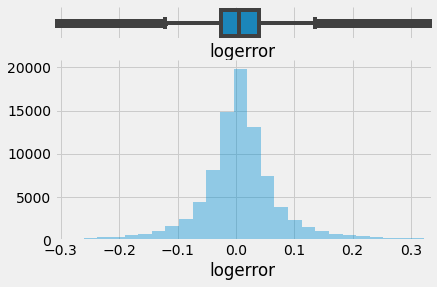

In [36]:
x = df_train['logerror']
f, (ax_box, ax_hist) = plt.subplots(2 , sharex='all', gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist, bins=400, kde=False)
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.xlim([me-2*st, me+2*st])
plt.show()

We get that the distribution spikes which very close to zero
Zillow has Good Data Scientists

### 3. Multivariate Analysis.

#### 3.1 Target Variable Distribution Join Fips by Bokeh
Reference - Philipp Spachtholz FanNotebook, we introduce Absolute logerror and FIPS codes map to city.

In [37]:
df_train.loc[:,'abs_logerror'] = df_train['logerror'].abs()

Transaction Date Vs Mean Error in each County

In [48]:
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show

fips1 = pd.DataFrame(df_train.loc[df_train['fips']==6037].groupby('transactiondate')['abs_logerror'].mean())
fips1.reset_index(inplace = True)
fips2 = pd.DataFrame(df_train.loc[df_train['fips']==6059].groupby('transactiondate')['abs_logerror'].mean())
fips2.reset_index(inplace = True)
fips3 = pd.DataFrame(df_train.loc[df_train['fips']==6111].groupby('transactiondate')['abs_logerror'].mean())
fips3.reset_index(inplace = True)


output_notebook()
out = figure(plot_width=800, plot_height=250, x_axis_type="datetime")

for data, name, color in zip([fips1, fips2, fips3], ["Los Angeles", "Orange County", "Ventura County"], Spectral4):

    out.line(data['transactiondate'], data['abs_logerror'], line_width=2, color=color, alpha=0.8, legend_label=name)

out.legend.location = "top_left"
out.legend.click_policy="hide"
show(out)

Loading BokehJS ...

Year Build Vs Mean Error in each County

In [49]:
fips1 = pd.DataFrame(df_train.loc[df_train['fips']==6037].groupby('yearbuilt')['abs_logerror'].mean())
fips1.reset_index(inplace = True)
fips2 = pd.DataFrame(df_train.loc[df_train['fips']==6059].groupby('yearbuilt')['abs_logerror'].mean())
fips2.reset_index(inplace = True)
fips3 = pd.DataFrame(df_train.loc[df_train['fips']==6111].groupby('yearbuilt')['abs_logerror'].mean())
fips3.reset_index(inplace = True)

output_notebook()
out = figure(plot_width=800, plot_height=250)

for data, name, color in zip([fips1, fips2, fips3], ["Los Angeles", "Orange County", "Ventura County"], Spectral4):

    out.line(data['yearbuilt'], data['abs_logerror'], line_width=2, color=color, alpha=0.8, legend_label=name)

out.legend.location = "top_right"
out.legend.click_policy="hide"
show(out)

Loading BokehJS ...

**An important note:**
- Ventura Country has Spikes means Zillow Estimation Inaccurate

In [50]:
import plotly # visualization
from plotly.graph_objs import Scatter, Figure, Layout # visualization
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot # visualization
import plotly.figure_factory as ff # visualization
import plotly.graph_objs as go # visualization
init_notebook_mode(connected=True) # visualization

worst_prediction = df_train['abs_logerror'].quantile(q=.95)


trace0 = go.Scatter(
    y = df_train[(df_train['fips']==6037)&(df_train['abs_logerror']>worst_prediction)].
        groupby('yearbuilt')['abs_logerror'].mean(),
    x = df_train[(df_train['fips']==6037)&(df_train['abs_logerror']>worst_prediction)].
        groupby('yearbuilt')['abs_logerror'].mean().index,
    mode = 'lines+markers',
    name = "Los Angeles",
)
trace1 = go.Scatter(
    y = df_train[(df_train['fips']==6059)&(df_train['abs_logerror']>worst_prediction)].
        groupby('yearbuilt')['abs_logerror'].mean(),
    x = df_train[(df_train['fips']==6059)&(df_train['abs_logerror']>worst_prediction)].
        groupby('yearbuilt')['abs_logerror'].mean().index,
    mode = 'lines+markers',
    name = "Orange County"
)
trace2 = go.Scatter(
    y = df_train[(df_train['fips']==6111)&(df_train['abs_logerror']>worst_prediction)].
        groupby('yearbuilt')['abs_logerror'].mean(),
    x = df_train[(df_train['fips']==6111)&(df_train['abs_logerror']>worst_prediction)].
        groupby('yearbuilt')['abs_logerror'].mean().index,
    mode = 'lines+markers',
    name = "Ventura County"
)
data = [trace0, trace1, trace2]

plotly.offline.iplot(data, filename='line-mode')

#### 3.2 Geographic Location by Folium and Cluster by KMeans¶

**Introduction:**
- Folium builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the Leaflet.js library.

- Manipulate your data in Python, then visualize it in on a Leaflet map via Folium.

In [51]:
geo_df = df_train[['latitude', 'longitude','logerror']]

In [52]:
geo_df['longitude']/=1e6
geo_df['latitude']/=1e6

In [53]:
geo_df.dropna(subset=['latitude','longitude'], axis=0 ,inplace=True)

In [56]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=120, batch_size=1000).fit(geo_df[['latitude','longitude']])
geo_df.loc[:, 'label'] = kmeans.labels_

In [80]:
map_2 = folium.Map(location=[34.088537, -118.249923], zoom_start=9)
for label in kmeans.cluster_centers_:
    folium.Marker(location=(label[0], label[1])).add_to(map_2)

map_2

In [81]:
map_1 = folium.Map(location=[34.088537, -118.249923], zoom_start=9,
                   tiles='Stamen Terrain')
for label in kmeans.cluster_centers_:
    folium.Marker(location=(label[0], label[1])).add_to(map_1)
map_1

In [82]:
del map_2 ,map_1
gc.collect()

826

**Finding:**
- Most houses locat in Flat Ground
- Few locat in Santa Catalina Island

#### 3.3 Where are the Perfect Estimation area ?
- We are going to have a look
- Ignoring Time Series, i.e Without taking month into consideration

In [83]:
gc.collect()
perfect_geo_df = geo_df[geo_df['logerror']==0]
perfect_geo_df.shape

(847, 4)

In [84]:
map_perfect = folium.Map(location=[34.088537, -118.249923], zoom_start=9,
                         tiles='Stamen Toner')
for lat, lon in zip(perfect_geo_df.latitude, perfect_geo_df.longitude):
    folium.Marker(location=[lat,lon]).add_to(map_perfect)
map_perfect

In [85]:
del perfect_geo_df, map_perfect, geo_df
gc.collect()

51

**An important note:**
- There is no pattern between Geo and perfect Estimation
- Never Happen in the Santa Catalina Island (Millionair hard to predict :-) )

### 4. Time Series Approach

#### 4.1 Aggragation & Visualisation

OverAll Average Absolute Log Error

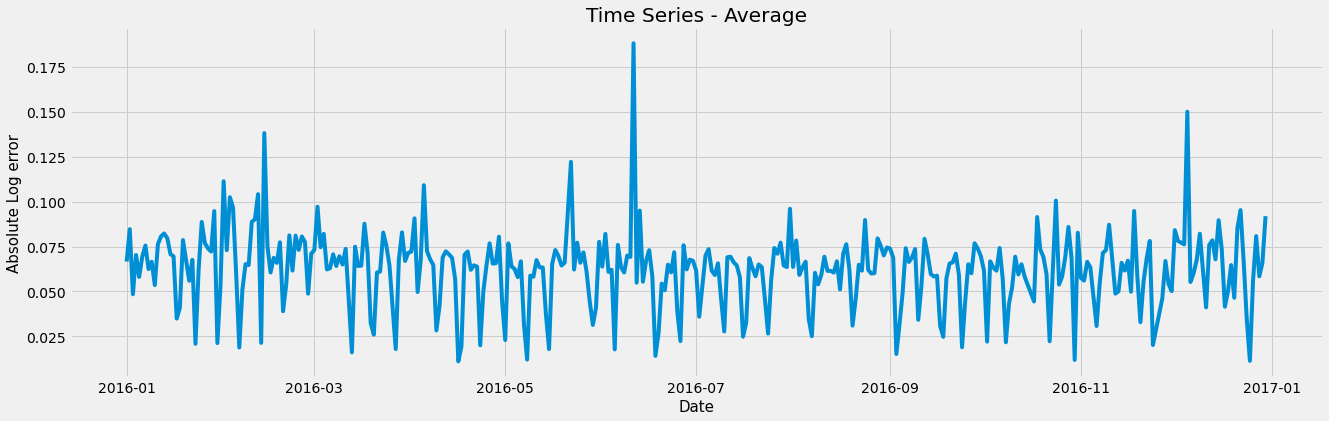

In [88]:
plt.figure(figsize=(20, 6))
mean_group = df_train[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].mean()
plt.plot(mean_group)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series - Average')
plt.show()

Los Angeles Average Absolute Log error

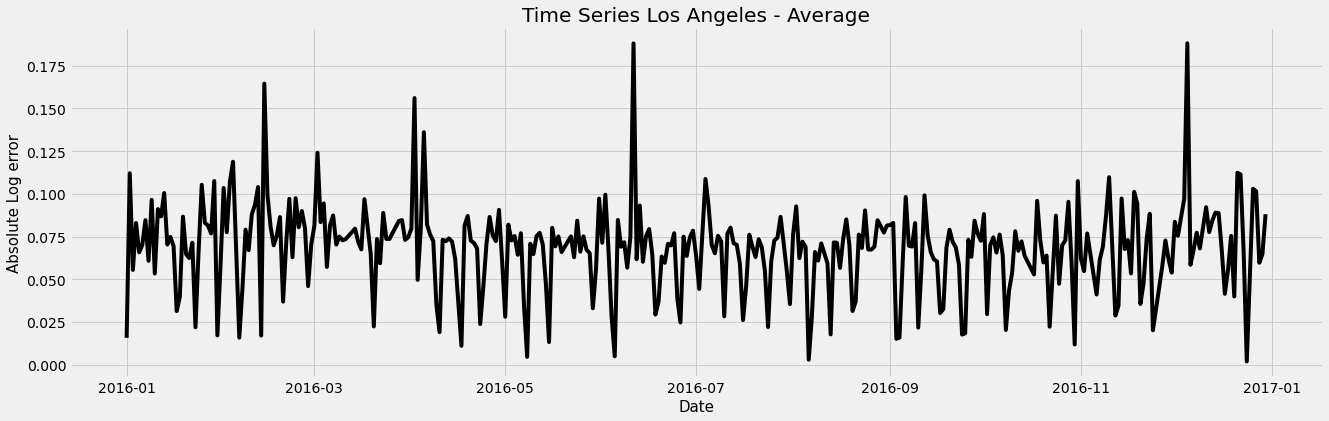

In [90]:
plt.figure(figsize=(20, 6))
fips1 = pd.DataFrame(df_train.loc[df_train['fips']==6037].groupby('transactiondate')['abs_logerror'].mean())
plt.plot(fips1,c='k')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series Los Angeles - Average')
plt.show()

Orange County Average Absolute Log error

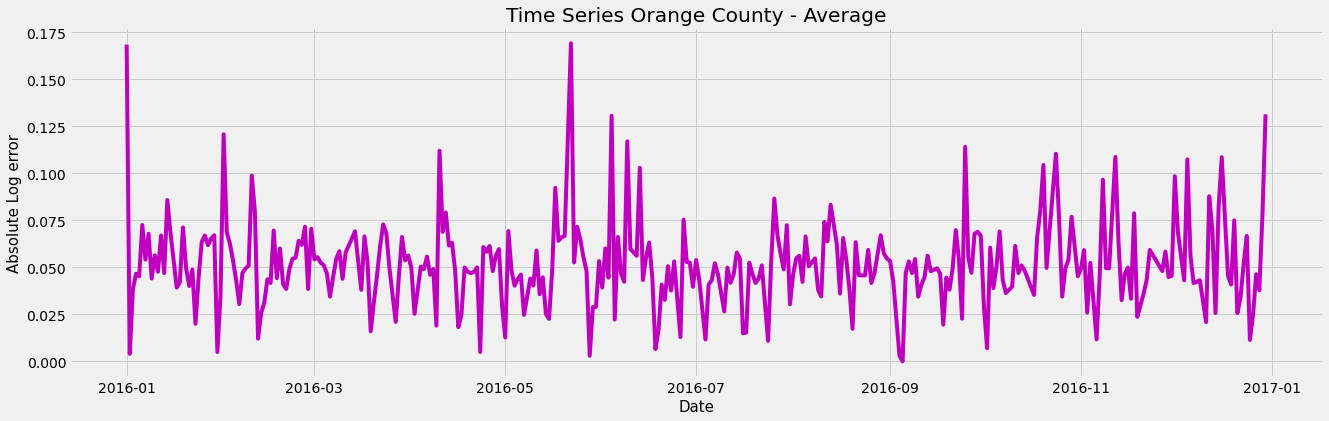

In [91]:
plt.figure(figsize=(20, 6))
fips1 = pd.DataFrame(df_train.loc[df_train['fips']==6059].groupby('transactiondate')['abs_logerror'].mean())
plt.plot(fips1, c = 'm')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series Orange County - Average')
plt.show()

Ventura County Average Absolute Log error

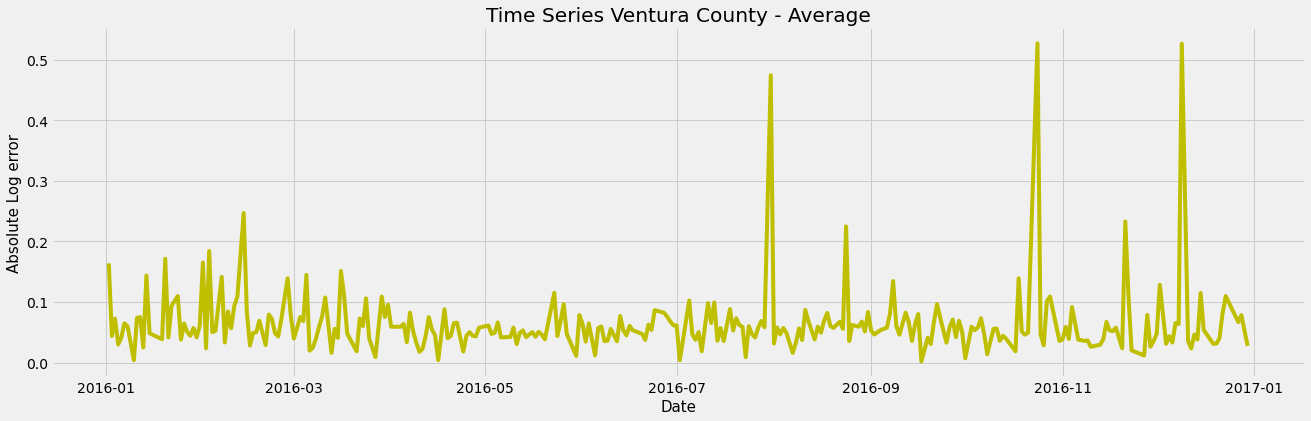

In [92]:
plt.figure(figsize=(20, 6))
fips1 = pd.DataFrame(df_train.loc[df_train['fips']==6111].groupby('transactiondate')['abs_logerror'].mean())
plt.plot(fips1, c = 'y')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series Ventura County - Average')
plt.show()

Median of Absolute Logerror

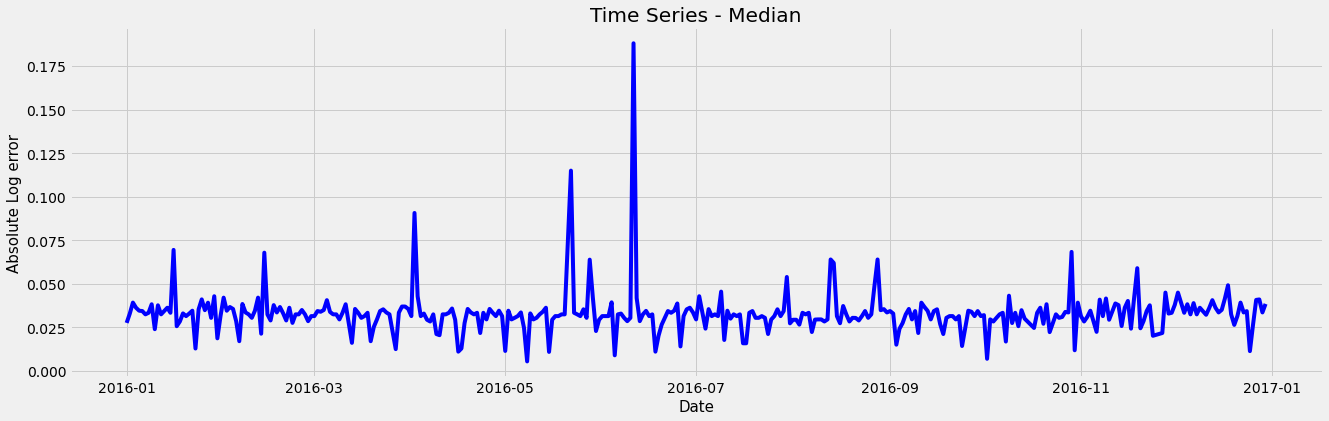

In [93]:
plt.figure(figsize=(20, 6))
median_group = df_train[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].median()
plt.plot(median_group, c='b')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series - Median')
plt.show()

Standard Deviation of Absolute Logerror

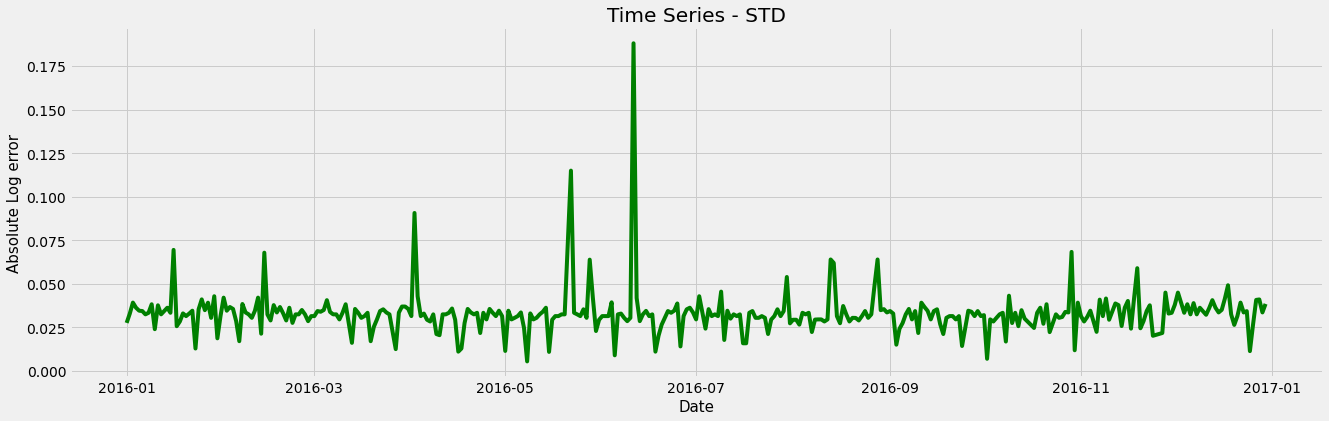

In [94]:
plt.figure(figsize=(20, 6))
std_group = df_train[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].median()
plt.plot(std_group, c='g')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series - STD')
plt.show()

In [95]:
del mean_group, median_group, std_group
gc.collect()

21600

Here, I only use inliner

- Definition:  Absolute Logerror < Mean + Std

In [96]:
df_train = df_train[df_train['abs_logerror']<  me + st ]
mean_group = df_train[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].mean()

##### Time Series Components
- A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise. These components are defined as follows:

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

##### Combining Time Series Components
- A series is thought to be an aggregate or combination of these four components. All series have a level and noise. The trend and seasonality components are optional. It is helpful to think of the components as combining either additively or multiplicatively.

-- Additive Model y(t) = Level + Trend + Seasonality + Noise

-- Multiplicative Model y(t) = Level x Trend x Seasonality x Noise


* Additive Model

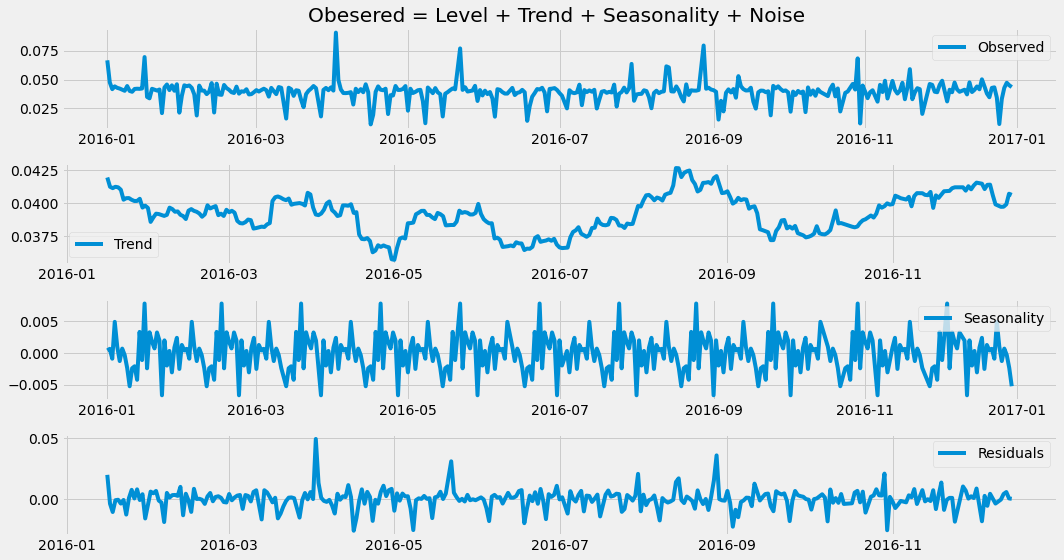

In [97]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
df_date_index = times_series_means[['transactiondate','abs_logerror']].set_index('transactiondate')
decomposition = sm.tsa.seasonal_decompose(df_date_index, model='additive',freq = 31)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
rcParams['figure.figsize'] = 15, 8

plt.subplot(411)
plt.title('Obesered = Level + Trend + Seasonality + Noise ')
plt.plot(df_date_index, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

* Multiplicative

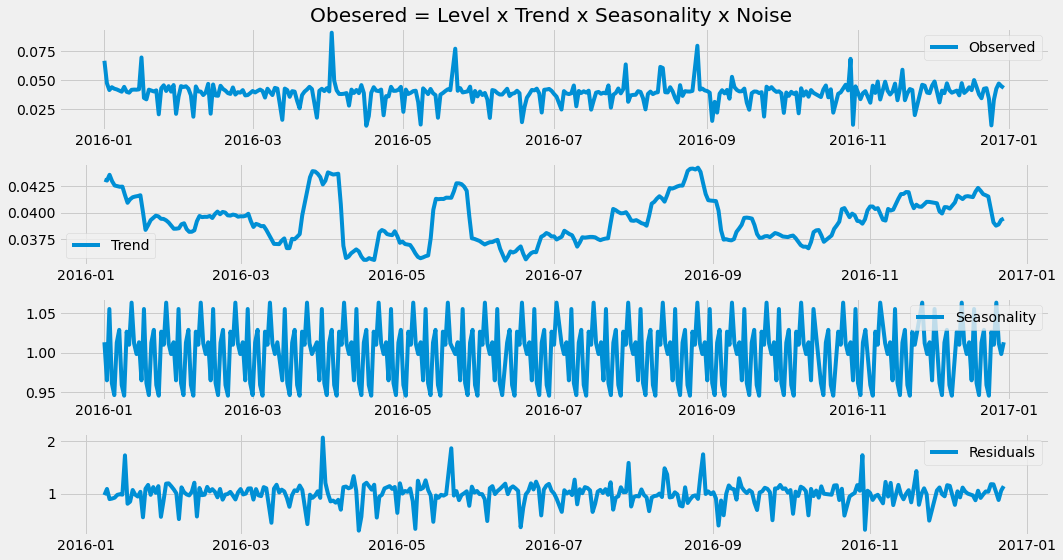

In [98]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
df_date_index = times_series_means[['transactiondate','abs_logerror']].set_index('transactiondate')
decomposition = sm.tsa.seasonal_decompose(df_date_index, model='multiplicative',freq = 14)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
rcParams['figure.figsize'] = 15, 8

plt.subplot(411)
plt.title('Obesered = Level x Trend x Seasonality x Noise ')
plt.plot(df_date_index, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### 4.2 Moving Average Smoothing / Random Walk and Stationarity

Moving average smoothing is a naive and effective technique in time series forecasting. It can be used for data preparation, feature engineering, and even directly for making predictions.

A stationary time series is one where the values are not a function of time. We can confirm this using a statistical significance test, specifically the Augmented Dickey-Fuller test.

* The script is copied from kaggler
Julien Heiduk and
https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
Dr. Jason Brownlee

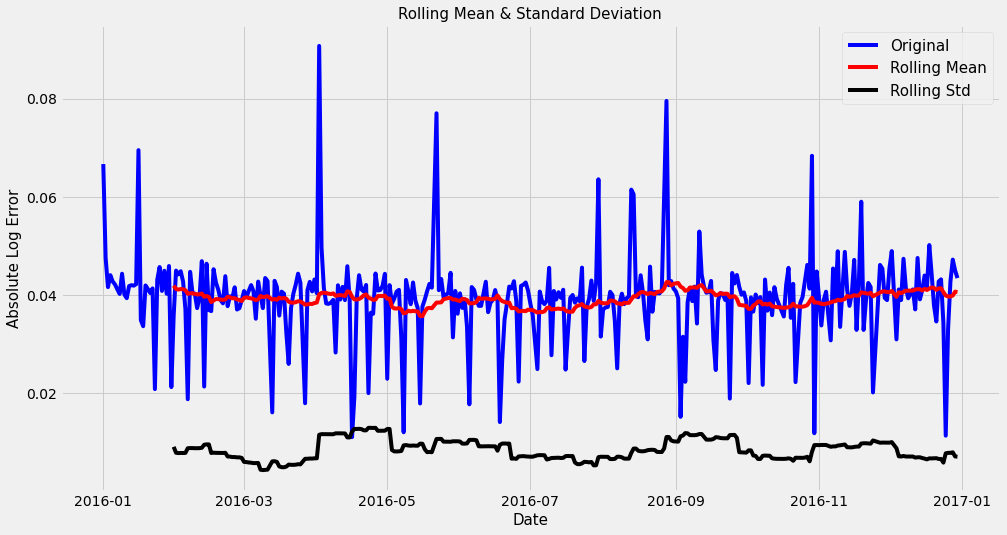

Results of Dickey-Fuller Test:
Test Statistic                -1.736474e+01
p-value                        5.179029e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.500000e+02
Critical Value (1%)           -3.449173e+00
Critical Value (5%)           -2.869833e+00
Critical Value (10%)          -2.571188e+00
dtype: float64


In [101]:
def test_stationarity(timeseries):
    plt.figure(figsize=(15, 8))
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=31).mean() # Slide window depend on past 1 month
    rolstd = timeseries.rolling(window=31).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best', fontsize=15)
    plt.title('Rolling Mean & Standard Deviation', fontsize=15)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Absolute Log Error', fontsize=15)
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries['abs_logerror'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df_date_index)

The **null hypothesis** of the test is that the time series is **non-stationary** and we can see that the test statistic value was **-1.736474e+01** with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is **stationary** or does not have time-dependent structure.

Non Time Dependent Structure
- Under Constraint
-- Exclude Outlier
-- Only depend on past 3 months

#### 4.3 Prophet Forecasting

This is inspired by kaggler Julien Heiduk
This tool was created by Facebook. More information on the library here: https://research.fb.com/prophet-forecasting-at-scale/

In [106]:
sns.set(font_scale=1)
df_prophet =  pd.DataFrame(mean_group).reset_index(drop=False)
df_prophet = df_prophet.iloc[-92:,:] # Forecast due to past 3 months
df_prophet.columns = ['ds','y']

m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=59,freq='D') # Forecast Jan 2017
forecast = m.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -54.2906
Iteration  1. Log joint probability =    97.3183. Improved by 151.609.
Iteration  2. Log joint probability =    143.423. Improved by 46.1052.
Iteration  3. Log joint probability =    154.436. Improved by 11.0124.
Iteration  4. Log joint probability =    154.841. Improved by 0.404865.
Iteration  5. Log joint probability =    154.866. Improved by 0.0257226.
Iteration  6. Log joint probability =    154.876. Improved by 0.00923595.
Iteration  7. Log joint probability =    154.898. Improved by 0.022453.
Iteration  8. Log joint probability =    154.916. Improved by 0.0178193.
Iteration  9. Log joint probability =    154.925. Improved by 0.00899763.
Iteration 10. Log joint probability =    154.927. Improved by 0.00165329.
Iteration 11. Log joint probability =    154.955. Improved by 0.0279669.
Iteration 12. Log joint probability =    154.957. Improved by 0.00215621.
Iteration 13. Log joint probability =    154.964. Improved by 0.0073148.
Iteration 14.

<Figure size 2160x432 with 0 Axes>

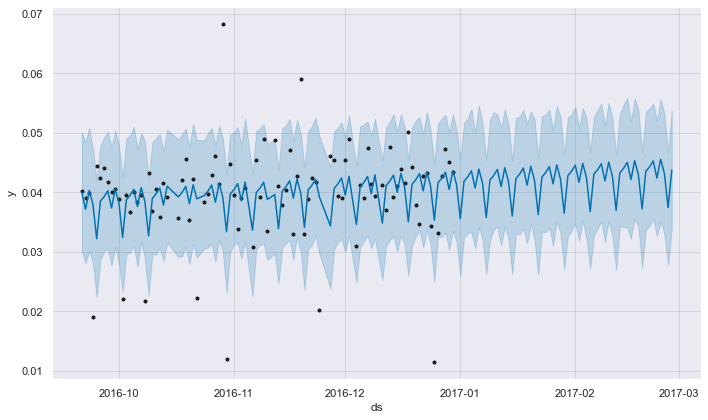

In [107]:
plt.figure(figsize=(30, 6))
fig = m.plot(forecast)
plt.show()